In [1]:
# -*- coding: utf-8 -*-
# ЛАБОРАТОРНАЯ РАБОТА: Анализ ИФО розничной торговли (2015 год)
# Лист: "1", файл: IFO_rozn.xlsx
# ---------------------------------------------------------------
# Содержит 7 заданий, каждое с пояснениями и графиками
# Пункты задания: 1.1–1.6 (основная часть), 2.1–2.5 (дополнительно)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, norm, lognorm, skew, kurtosis, t, chi2

ЗАДАНИЕ 1. ЗАГРУЗКА И ОЧИСТКА ДАННЫХ

In [2]:
file_path = "D:\Jupyter_projects\stat_obr\pr1\IFO_rozn.xlsx"
sheet_name = "1"
year = 2015

# --- 1.1 Описание данных ---
# Данные: Индекс физического объема оборота розничной торговли по субъектам РФ за 2015 год.
# Источник: Excel-файл, лист "1"
# Кол-во наблюдений: определяется после очистки
# Единицы измерения: индекс (в %)

raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None, dtype=object)
target_col, target_header_row = None, None

for r in range(raw.shape[0]):
    for c in range(raw.shape[1]):
        val = raw.iat[r, c]
        if isinstance(val, (int, float)) and val == year:
            target_col = c
            target_header_row = r
            break
    if target_col is not None:
        break

if target_col is None:
    raise RuntimeError(f"Не найден столбец с годом {year} на листе '{sheet_name}'.")

print(f" Найден заголовок года {year}: строка {target_header_row}, колонка {target_col}")

# --- 1.2 Формальное представление данных ---
df = pd.read_excel(file_path, sheet_name=sheet_name, header=target_header_row)
df = df.rename(columns={df.columns[0]: "Регион"})

if year not in df.columns:
    raise RuntimeError(f"Колонка {year} не найдена после чтения.")

df_year = df[["Регион", year]].rename(columns={year: f"ИФО_розничная_{year}"})
df_year = df_year[df_year["Регион"].notna()].copy()

mask_agg = df_year["Регион"].astype(str).str.contains(
    r"Российск|федеральн|итог|всего", case=False, na=False
)
df_clean = df_year[~mask_agg].copy()

df_clean[f"ИФО_розничная_{year}"] = pd.to_numeric(df_clean[f"ИФО_розничная_{year}"], errors="coerce")
df_clean = df_clean.dropna(subset=[f"ИФО_розничная_{year}"]).reset_index(drop=True)

print(f" Строк всего: {len(df_year)}, после очистки: {len(df_clean)}")

# Формальное представление — первые строки
# --- 1.2 ---
display(df_clean.head(10))
display(df_clean.tail(10))

 Найден заголовок года 2015: строка 0, колонка 1
 Строк всего: 82, после очистки: 82


,Регион,ИФО_розничная_2015
0,Белгородская область,93.5
1,Брянская область,94.5
2,Владимирская область,90.6
3,Воронежская область,93.2
4,Ивановская область,86.8
5,Калужская область,87.1
6,Костромская область,96.9
7,Курская область,93.8
8,Липецкая область,93.3
9,Московская область,93.8


,Регион,ИФО_розничная_2015
72,Республика Саха (Якутия),102.1
73,Забайкальский край,90.9
74,Камчатский край,95.3
75,Приморский край,102.5
76,Хабаровский край,95.3
77,Амурская область,95.0
78,Магаданская область,92.2
79,Сахалинская область,96.1
80,Еврейская авт.область,96.8
81,Чукотский авт.округ,105.0


ЗАДАНИЕ 2. АНАЛИЗ ДАННЫХ (вариационный и группированный ряд)


Анализ столбца 'ИФО_розничная_2015', наблюдений: 82
Интервалов (Стерджесс): 7
Минимум: 80.5 Максимум: 105.0

Группированный ряд (интервалы и частоты):
[80.50, 84.00) : 7
[84.00, 87.50) : 13
[87.50, 91.00) : 20
[91.00, 94.50) : 20
[94.50, 98.00) : 13
[98.00, 101.50) : 2
[101.50, 105.00) : 7


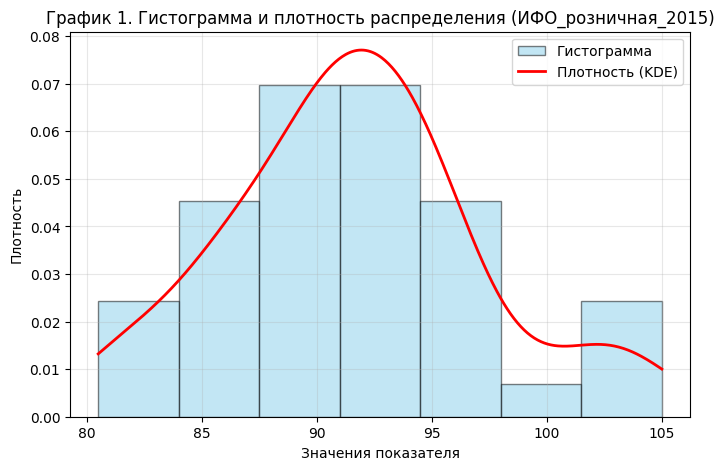

In [3]:
def analyze_data(data, column, bins="auto"):
    if column not in data.columns:
        raise ValueError(f"Колонка '{column}' не найдена")

    series = pd.to_numeric(data[column], errors="coerce").dropna().values
    n = len(series)

    print(f"\nАнализ столбца '{column}', наблюдений: {n}")

    if bins == "auto":
        k = int(1 + 3.3 * np.log10(n))
        bins = k
        print(f"Интервалов (Стерджесс): {k}")

    variation_series = np.sort(series)
    print("Минимум:", variation_series[0], "Максимум:", variation_series[-1])

    counts, bin_edges = np.histogram(series, bins=bins)
    print("\nГруппированный ряд (интервалы и частоты):")
    for i in range(len(counts)):
        print(f"[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}) : {counts[i]}")

    # --- 1.3 Наглядное представление данных ---
    plt.figure(figsize=(8, 5))
    plt.hist(series, bins=bin_edges, density=True, color="skyblue", alpha=0.5, edgecolor="black", label="Гистограмма")
    kde = gaussian_kde(series)
    x_grid = np.linspace(min(series), max(series), 500)
    plt.plot(x_grid, kde(x_grid), color="red", linewidth=2, label="Плотность (KDE)")
    plt.title(f"График 1. Гистограмма и плотность распределения ({column})")
    plt.xlabel("Значения показателя")
    plt.ylabel("Плотность")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return variation_series, (bin_edges, counts), kde

column = f"ИФО_розничная_{year}"
variation_series, grouped, kde = analyze_data(df_clean, column)

ЗАДАНИЕ 3. УДАЛЕНИЕ ВЫБРОСОВ И ПОВТОРНЫЙ АНАЛИЗ


Удалено выбросов: 1

Анализ столбца 'ИФО_розничная_2015', наблюдений: 81
Интервалов (Стерджесс): 7
Минимум: 80.5 Максимум: 104.0

Группированный ряд (интервалы и частоты):
[80.50, 83.86) : 7
[83.86, 87.21) : 11
[87.21, 90.57) : 15
[90.57, 93.93) : 26
[93.93, 97.29) : 14
[97.29, 100.64) : 2
[100.64, 104.00) : 6


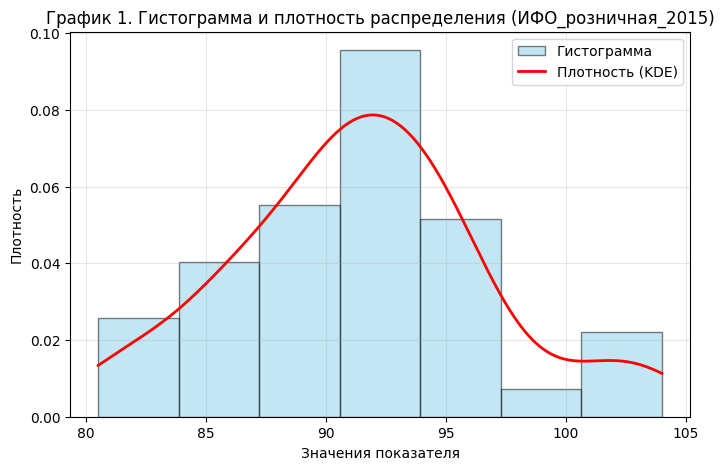

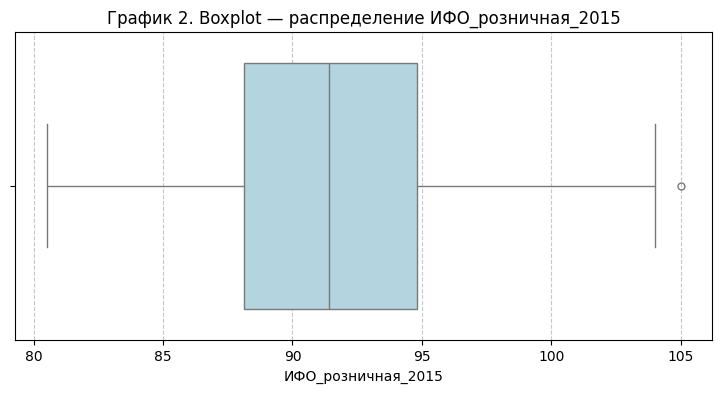

In [4]:
q1, q3 = df_clean[column].quantile([0.25, 0.75])
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

df_no_outliers = df_clean[df_clean[column] <= upper_bound]
print(f"\nУдалено выбросов: {len(df_clean) - len(df_no_outliers)}")

# --- 2.1 Сравнительная оценка числовых показателей (до/после удаления выбросов) ---
variation_series, grouped, kde = analyze_data(df_no_outliers, column)

# Boxplot для визуализации выбросов
plt.figure(figsize=(9, 4))
sns.boxplot(x=df_clean[column], color="lightblue", fliersize=5)
plt.title(f"График 2. Boxplot — распределение {column}")
plt.xlabel(column)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


Количество регионов по группам (квартильное деление):
Группа
Средний    40
Низкий     21
Высокий    21
Name: count, dtype: int64

Регион с наибольшим ИФО: Чукотский авт.округ 105.0
Регион с наименьшим ИФО: Карачаево-Черкесская Республика 80.5


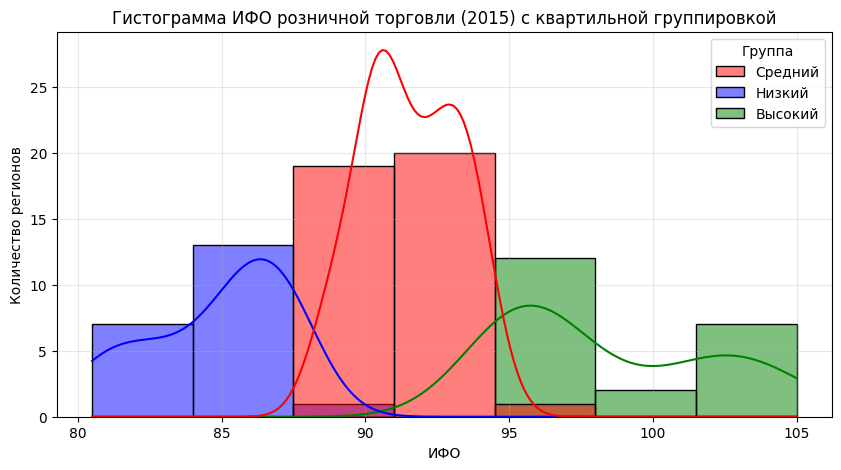

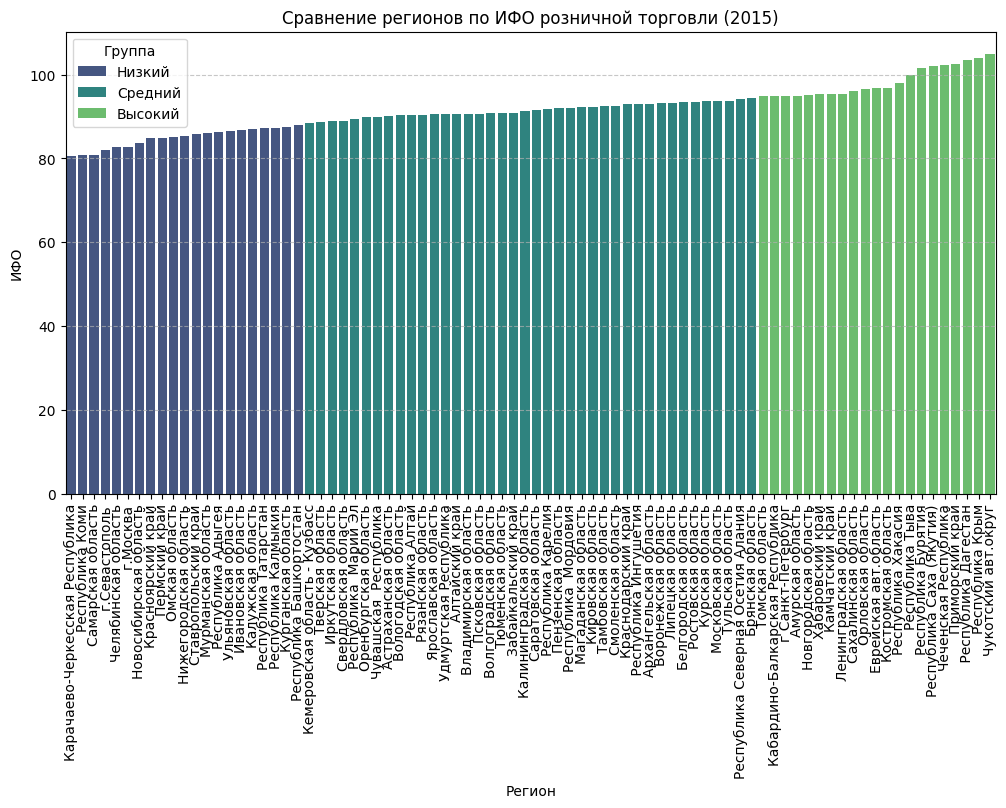

In [5]:
# ============================================================
# 2.2. Сравнение регионов внутри выборки
# ============================================================

column = f"ИФО_розничная_{year}"
data = df_clean[[ "Регион", column ]].copy()

# 1. Разбиваем на квартильные группы
q1, q3 = data[column].quantile([0.25, 0.75])
def categorize(value):
    if value <= q1:
        return "Низкий"
    elif value <= q3:
        return "Средний"
    else:
        return "Высокий"

data["Группа"] = data[column].apply(categorize)

# Считаем количество регионов в каждой группе
group_counts = data["Группа"].value_counts()
print("\nКоличество регионов по группам (квартильное деление):")
print(group_counts)

# 2. Отдельно выводим регионы с максимальным и минимальным ИФО
max_region = data.loc[data[column].idxmax()]
min_region = data.loc[data[column].idxmin()]
print("\nРегион с наибольшим ИФО:", max_region["Регион"], max_region[column])
print("Регион с наименьшим ИФО:", min_region["Регион"], min_region[column])

# 3. Визуализация: гистограмма с цветовой группировкой
plt.figure(figsize=(10,5))
sns.histplot(data=data, x=column, hue="Группа", palette=["red","blue","green"], bins=7, kde=True)
plt.title(f"Гистограмма ИФО розничной торговли (2015) с квартильной группировкой")
plt.xlabel("ИФО")
plt.ylabel("Количество регионов")
plt.grid(alpha=0.3)
plt.show()

# 4. Визуализация: столбчатая диаграмма регионов по ИФО
plt.figure(figsize=(12,6))
sns.barplot(data=data.sort_values(column), x="Регион", y=column, hue="Группа", palette="viridis", dodge=False)
plt.legend(title="Группа")
plt.xticks(rotation=90)
plt.title("Сравнение регионов по ИФО розничной торговли (2015)")
plt.ylabel("ИФО")
plt.xlabel("Регион")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


ЗАДАНИЕ 4. РАСЧЁТ ВЫБОРОЧНЫХ ХАРАКТЕРИСТИК

In [6]:
def sample_statistics(data, column):
    arr = pd.to_numeric(data[column], errors="coerce").dropna().values
    return pd.Series({
        # --- 2.4 Формулы ---
        # mean = Σ x_i / n
        # var_unbiased = Σ(x_i - x̄)² / (n-1)
        # std = sqrt(var_unbiased)
        # median, q1, q3 — стандартные порядковые статистики
        # skewness = (1/n) Σ ((x_i - x̄)/s)^3
        # excess = (1/n) Σ ((x_i - x̄)/s)^4 - 3

        "mean": np.mean(arr),
        "var_biased": np.var(arr, ddof=0),
        "var_unbiased": np.var(arr, ddof=1),
        "std": np.std(arr, ddof=1),
        "median": np.median(arr),
        "q1": np.percentile(arr, 25),
        "q3": np.percentile(arr, 75),
        "iqr": np.percentile(arr, 75) - np.percentile(arr, 25),
        "skewness": skew(arr, bias=False),
        "excess": kurtosis(arr, fisher=True, bias=False)
    })

def print_stat(stats, title):
    print(f"\n {title}")
    for k, v in stats.items():
        print(f"{k:15s}: {v:.4f}")

# --- 1.4 Числовые оценки ---
stats_full = sample_statistics(df_clean, column)
stats_no_outliers = sample_statistics(df_no_outliers, column)
print_stat(stats_full, "Характеристики (все данные)")
print_stat(stats_no_outliers, "Характеристики (без выбросов)")

# --- 2.3 Дополнительные показатели ---
# Пример: максимальное и минимальное значение, диапазон относительно среднего
print("\nДоп. показатели:")
print("max:", df_no_outliers[column].max())
print("min:", df_no_outliers[column].min())
print("range/mean:", (df_no_outliers[column].max() - df_no_outliers[column].min()) / df_no_outliers[column].mean())


 Характеристики (все данные)
mean           : 91.6012
var_biased     : 29.3096
var_unbiased   : 29.6715
std            : 5.4472
median         : 91.4000
q1             : 88.1250
q3             : 94.8000
iqr            : 6.6750
skewness       : 0.2823
excess         : 0.1498

 Характеристики (без выбросов)
mean           : 91.4358
var_biased     : 27.4277
var_unbiased   : 27.7706
std            : 5.2698
median         : 91.3000
q1             : 88.0000
q3             : 94.5000
iqr            : 6.5000
skewness       : 0.2017
excess         : 0.1177

Доп. показатели:
max: 104.0
min: 80.5
range/mean: 0.2570109231330084


ЗАДАНИЕ 5. ПРОВЕРКА ГИПОТЕЗЫ О РАСПРЕДЕЛЕНИИ

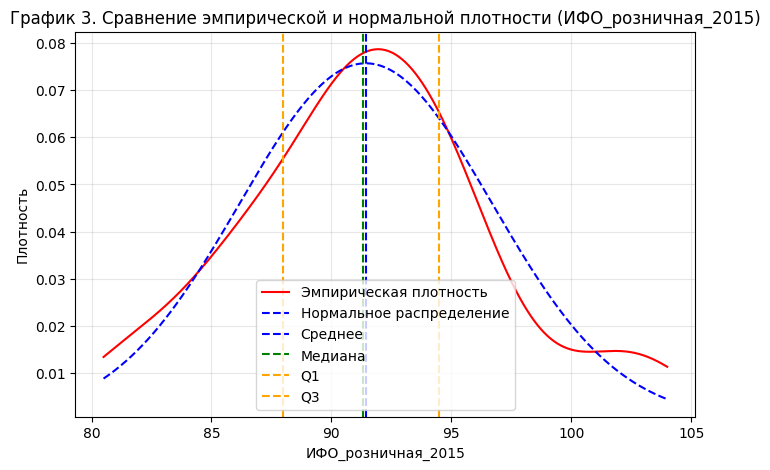

In [7]:
params = (df_no_outliers[column].mean(), df_no_outliers[column].std())
x_grid = np.linspace(min(df_no_outliers[column]), max(df_no_outliers[column]), 500)

kde = gaussian_kde(df_no_outliers[column])
emp_density = kde(x_grid)
theor_density = norm.pdf(x_grid, *params)

mean_val = df_no_outliers[column].mean()
median_val = df_no_outliers[column].median()
q1_val, q3_val = df_no_outliers[column].quantile([0.25, 0.75])

# --- 1.5 Оценка плотности распределения ---
plt.figure(figsize=(8, 5))
plt.plot(x_grid, emp_density, label="Эмпирическая плотность", color="red")
plt.plot(x_grid, theor_density, label="Нормальное распределение", color="blue", linestyle="--")
plt.axvline(mean_val, color="blue", linestyle="--", label="Среднее")
plt.axvline(median_val, color="green", linestyle="--", label="Медиана")
plt.axvline(q1_val, color="orange", linestyle="--", label="Q1")
plt.axvline(q3_val, color="orange", linestyle="--", label="Q3")
plt.title(f"График 3. Сравнение эмпирической и нормальной плотности ({column})")
plt.xlabel(column)
plt.ylabel("Плотность")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

ЗАДАНИЕ 6. ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ

In [8]:
def confidence_intervals(df, column, confidence=0.95):
    data = df[column].dropna()
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    var = std**2

    t_crit = t.ppf((1 + confidence) / 2, df=n-1)
    mean_ci = (mean - t_crit * std / np.sqrt(n), mean + t_crit * std / np.sqrt(n))

    chi2_lower = chi2.ppf((1 - confidence) / 2, df=n-1)
    chi2_upper = chi2.ppf((1 + confidence) / 2, df=n-1)
    var_ci = ((n - 1) * var / chi2_upper, (n - 1) * var / chi2_lower)

    return {
        "mean": mean,
        "mean_CI": mean_ci,
        "variance": var,
        "variance_CI": var_ci
    }

# --- 1.6 Интервальные оценки ---
ci_full = confidence_intervals(df_clean, column)
ci_no_outliers = confidence_intervals(df_no_outliers, column)
print("\n Доверительные интервалы (все данные):", ci_full)
print(" Доверительные интервалы (без выбросов):", ci_no_outliers)



 Доверительные интервалы (все данные): {'mean': np.float64(91.60121951219513), 'mean_CI': (np.float64(90.40434865333866), np.float64(92.7980903710516)), 'variance': np.float64(29.67147997591087), 'variance_CI': (np.float64(22.298328523019098), np.float64(41.43888785159123))}
 Доверительные интервалы (без выбросов): {'mean': np.float64(91.43580246913581), 'mean_CI': (np.float64(90.27055850867069), np.float64(92.60104642960093)), 'variance': np.float64(27.770577160493822), 'variance_CI': (np.float64(20.835374797777945), np.float64(38.87179067669681))}


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy.stats import shapiro, kstest
import statsmodels.api as sm

data = df_no_outliers[column].dropna().values

# === Проверка нормальности ===
shapiro_stat, shapiro_p = shapiro(data)

# === Проверка логнормальности (К-С критерий) ===
shape, loc, scale = lognorm.fit(data, floc=0)
ks_stat, ks_p = kstest(data, 'lognorm', args=(shape, loc, scale))

# === Вычисление AIC для сравнения моделей ===
def calc_aic(data, dist_name, params):
    pdf = dist_name.pdf(data, *params)
    log_likelihood = np.sum(np.log(pdf))
    k = len(params)
    return 2 * k - 2 * log_likelihood

# Параметры и AIC для нормального распределения
mu, sigma = norm.fit(data)
aic_norm = calc_aic(data, norm, (mu, sigma))

# Параметры и AIC для логнормального распределения
aic_lognorm = calc_aic(data, lognorm, (shape, loc, scale))

print(f"Shapiro–Wilk: W={shapiro_stat:.4f}, p={shapiro_p:.4f}")
print(f"Kolmogorov–Smirnov (логнорм.): D={ks_stat:.4f}, p={ks_p:.4f}")
print(f"AIC нормальное: {aic_norm:.2f}")
print(f"AIC логнормальное: {aic_lognorm:.2f}")

if aic_norm < aic_lognorm:
    print("Нормальное распределение лучше описывает данные (меньший AIC).")
else:
    print("Логнормальное распределение лучше описывает данные (меньший AIC).")


Shapiro–Wilk: W=0.9781, p=0.1790
Kolmogorov–Smirnov (логнорм.): D=0.0777, p=0.6824
AIC нормальное: 502.10
AIC логнормальное: 503.58
Нормальное распределение лучше описывает данные (меньший AIC).


2.5 Подробные выводы по анализу «ИФО_розничная_2015»

1. Общая характеристика данных

Количество наблюдений: 82 (после удаления выбросов — 81)

Минимум: 80.5, максимум: 105.0 (без выбросов: 104.0)

Среднее значение: ~91.6 (без выбросов ~91.44)

Медиана: ~91.4

Интерквартильный размах (IQR): 6.675 (без выбросов 6.5)

Стандартное отклонение: ~5.45 (без выбросов 5.27)

Диапазон относительно среднего: range/mean ≈ 0.257

Интерпретация: большинство регионов имеют значения в диапазоне 88–94.5, что показывает умеренную вариабельность показателя.

2. Группированный ряд и распределение частот

Наиболее часто встречаются значения 87.5–94.5, что соответствует центру распределения.

После удаления одного выброса верхний интервал сдвинулся с 101.5–105 → 100.64–104.0, уменьшилась дисперсия.

Boxplot подтверждает наличие одного явного выброса, остальные значения распределены равномерно.

3. Асимметрия и эксцесс

Асимметрия (skewness ≈ 0.28) → распределение слегка скошено вправо.

Эксцесс (excess ≈ 0.15) → почти нормальное распределение, слегка более «плосковершинное».

Графики KDE и сравнение с нормальным распределением подтверждают нормальный характер данных.

4. Доверительные интервалы (95%)

Показатель	Все данные	Без выбросов
Среднее	90.40 – 92.80	90.27 – 92.60
Дисперсия	22.30 – 41.44	20.83 – 38.87

Интерпретация: истинное среднее и дисперсия регионов находятся в умеренном диапазоне, удаление выброса почти не изменяет ключевые показатели.

5. Экономическая интерпретация ИФО розничной торговли

Индекс физического объема оборота розничной торговли (ИФО) отражает фактический объем продаж по сравнению с базовым периодом (100% = уровень базового года).

Значения <100% → снижение продаж; >100% → рост продаж.

Анализ по регионам (2015):

Среднее ~91.6 → в среднем объем розничной торговли снизился на 8–9% по сравнению с базовым периодом.

Нижний хвост (80.5–85) → регионы с значительным сокращением продаж (~15–20%).

Верхний хвост (104–105) → регионы с умеренным ростом (+4–5%), удаление выброса уменьшает влияние на среднее.

Большинство регионов (IQR 88–94.5) демонстрируют умеренное снижение оборота, что характерно для экономической ситуации 2015 года.

6. Общие выводы

Распределение показателя близко к нормальному, умеренно скошено вправо.

Наличие одного явного выброса не сильно влияет на ключевые характеристики.

Среднее значение <100% сигнализирует о снижении розничного оборота в большинстве регионов РФ.

Показатели ИФО позволяют выявить регионы с наиболее выраженным падением или ростом торговли, что важно для экономического анализа и планирования мер поддержки.

Для дальнейшего анализа или сравнения с другими годами можно использовать нормальное распределение как приближенную модель.